# **DIVE INTO CODE COURSE**
## **Graduation Assignment**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

### **[Problem 1] Learning and Estimation**
Please refer to the README to run the above implementation.

In [65]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [86]:
!nvidia-smi

Tue Feb  8 01:42:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:20:00.0  On |                  N/A |
|  0%   51C    P8     9W / 200W |    633MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preprocessing Dataset 

In [66]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

In [67]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset


from PIL import Image

In [68]:
test = pd.read_csv('dataset/train/train_meta.csv')
test

,image_id,fname,mask,distancing,5k
0,1,1.jpg,1.0,1.0,1.0
1,2,2.jpg,0.0,NaN,NaN
2,3,3.jpg,1.0,1.0,1.0
3,4,4.jpg,1.0,1.0,1.0
4,5,5.jpg,0.0,0.0,0.0
...,...,...,...,...,...
4170,4171,4171.jpg,0.0,1.0,0.0
4171,4172,4172.jpg,1.0,1.0,1.0
4172,4173,4173.jpg,1.0,NaN,NaN
4173,4174,4174.jpg,1.0,1.0,1.0


In [82]:
class Data5K(Dataset):
    def __init__(self, path, csv_file='train_meta.csv', split='train', transform=None):
        self.path = path
        self.split = split
        self.transform = transform

        self.metadata = pd.read_csv(os.path.join(path, csv_file))

        if 'index' in self.metadata.columns:
            self.metadata.drop(columns=['index'], inplace = True)

        if 'Unnamed: 0' in self.metadata.columns:
            self.metadata.drop(columns=['Unnamed: 0'], inplace = True)

        self.metadata.dropna(inplace=True)
        self.metadata.reset_index(drop=True, inplace=True)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        row = self.metadata.loc[index]
        fname = row['fname']

        img = Image.open(os.path.join(self.path, 'images', fname)).convert(('RGB')) # Open image in gray mode initially and converted to RGB

        if self.transform is not None:
            img = self.transform(img)

        data = dict() # Return the dictionary of the corresponding row

        if self.split != 'test':
            mask = row['mask'] # Mask of people
            dist = row['dist'] # Distance between people

        fivek = row['5k']
        # If not NaN, format as int type (originally string)
        data['mask'] = mask if np.isnan(mask) else int(mask)
        data['dist'] = dist if np.isnan(dist) else int(dist)
        data['5k'] = fivek if np.isnan(fivek) else int(fivek)
        data['image'] = img

        return data

    def append_data(self, rows):
        self.meta = self.meta.append(rows)
        self.meta.reset_index(drop=True, inplace=True)

In [83]:
class UnlabeledData5K(Dataset):
    def __init__(self, path, csv_file='train_meta.csv', split='train', transform=None):
        self.path = path
        self.split = split
        self.transform = transform

        self.metadata = pd.read_csv(os.path.join(path, csv_file))
        
        self.metadata = self.metadata[self.metadata.isna().any(axis=1)] # Retrieve the rows that missing one of the features (mask, distance, 5k) or all
        self.metadata.reset_index(drop=True, inplace=True)

        if 'index' in self.metadata.columns:
            self.metadata.drop(columns=['index'], inplace = True)

        if 'Unnamed: 0' in self.metadata.columns:
            self.metadata.drop(columns=['Unnamed: 0'], inplace = True)
            

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        row = self.metadata.loc[index]
        fname = row['fname']

        img = Image.open(os.path.join(self.path, 'images', fname)).convert(('RGB')) # Open image in gray mode initially and converted to RGB

        if self.transform is not None:
            img = self.transform(img)

        data = dict() # Return the dictionary of the corresponding row

        if self.split != 'test':
            mask = row['mask'] # Mask of people
            dist = row['dist'] # Distance between people

        fivek = row['5k']
        # If not NaN, format as int type (originally string)
        data['mask'] = mask if np.isnan(mask) else int(mask)
        data['dist'] = dist if np.isnan(dist) else int(dist)
        data['5k'] = fivek if np.isnan(fivek) else int(fivek)
        data['index'] = index
        data['image'] = img

        return data

    def retrieve_data(self, indexes):
        rows = self.metadata.iloc[indexes]
        self.metadata.drop(self.metadata.index[indexes], inplace=True)
        self.metadata.reset_index(drop=True, inplace=True)

        return rows


## Plotting

In [71]:
import matplotlib.pyplot as plt

def split_train_val(path):
    metadata = pd.read_csv(os.path.join(path, 'train_meta.csv'))
    metadata.dropna(inplace=True)
    metadata.reset_index(inplace=True)

    val_row = metadata[metadata['5k'].notnull()]

    fig = plt.figure(figsize = (12,16))
    ax1 = fig.gca()
    val_row.hist(ax=ax1)
    fig.suptitle("Original data")

    df_val = val_row.sample(n=200)
    df_val.to_csv(os.path.join(path, 'train_meta_val.csv'))

    df_all = metadata.merge(df_val.drop_duplicates(), how='left', indicator=True)
    df_train = df_all[df_all['_merge'] == 'left_only'].drop('_merge', axis=1)
    df_train.to_csv(os.path.join(path, 'train_meta_train.csv'))

    fig = plt.figure(figsize = (12,16))
    ax2 = fig.gca()
    df_val.hist(ax=ax2)
    fig.suptitle("Validation data")

    # plt.show()

C:\Users\Bin\AppData\Local\Temp/ipykernel_15348/404917155.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  val_row.hist(ax=ax1)
C:\Users\Bin\AppData\Local\Temp/ipykernel_15348/404917155.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_val.hist(ax=ax2)


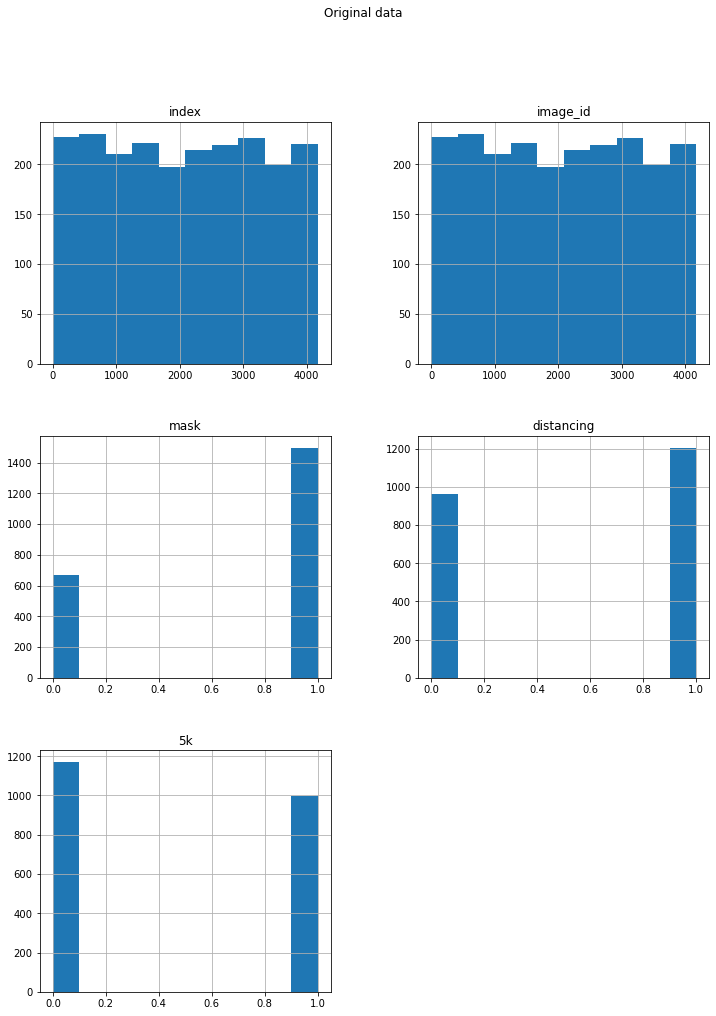

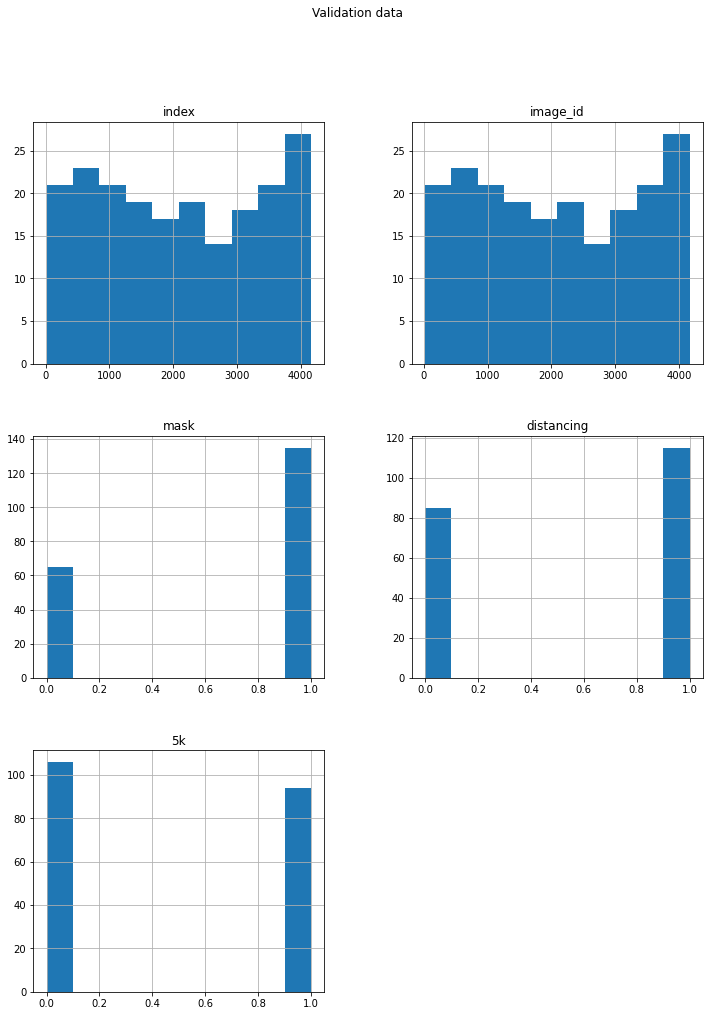

In [72]:
split_train_val('dataset/train')

## Transform Image

In [80]:
from torchvision import transforms

transforms_train_data = transforms.Compose([transforms.CenterCrop(500),
                                            transforms.RandomHorizontalFlip(p=0.42),
                                            transforms.Resize([320, 320]),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=(0.495, 0.465, 0.425), std=(0.221, 0.195, 0.212))
                                            ])

transforms_val_data = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize([320, 320]),
                                          transforms.Normalize(mean=(0.495, 0.465, 0.425), std=(0.221, 0.195, 0.212))
                                          ])

In [84]:
# Use the composed transformer above for train and validation dataset

# Labeled train dataset
labeled_train_data = Data5K('dataset/train', 'train_meta_train.csv', 'train', transforms_train_data)

# Unlabeled train dataset
unlabeled_train_data = UnlabeledData5K('dataset/train', 'train_meta.csv', 'train', transforms_train_data)

# Validation dataset
validation_data = Data5K('dataset/train/', 'train_meta_val.csv', 'valid', transforms_val_data)

## Wrap the Dataset into a Dataloader

In [ ]:
from torch.utils.data import DataLoader

labeled_train_loader = DataLoader(labeled_train_data, shuffle=True, batch_size=32)

unlabeled_train_loader = DataLoader(unlabeled_train_data, shuffle=True, batch_size=32)

validation_loader = DataLoader(validation_data, shuffle=True, batch_size=32)

## Modeling

In [ ]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet